# Assembly name prediction

In [32]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from tqdm import tqdm
from collections import Counter
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from numpy.linalg import norm
from transformers import BertTokenizer, TFBertModel, TFAutoModel
import tensorflow_addons as tfa

## Simple baseline with BERT and cosine similarity

### Pre-process data for task

In [4]:
data_path = "../data/data_02.feather"
data = pd.read_feather(data_path)

In [5]:
data = data.dropna(subset=["assembly_name", "part_names"])
data = data.drop(columns=["assembly_id", 'assembly_description'])
data.head()

,assembly_name,part_names
0,Lava Lamp 2,"[Blob3, Blob2, Blob1, Glass, Cap]"
1,Sample - Headphones,"[Pivot hinge, Headphone hinge, Telescope hinge..."
4,Coffee Mug,"[Mug, Lid]"
5,Dave's Handsome Mug,"[Lid, Seal, Vessel]"
9,Mechanical Pencil,"[Eraser, Pencil Lead, Rubber Grip, Gripper Rod..."


In [6]:
# Deduplicate
print(f"Tot: {len(data)}")
print(f"Unique: {len(data['assembly_name'].unique())}")
data = data[~data['part_names'].apply(tuple).duplicated()]
print(f"\nAfter dedup: {len(data)}")
print(f"Unique: {len(data['assembly_name'].unique())}")

Tot: 88886
Unique: 67834

After dedup: 61725
Unique: 54034


### Clean assembly names

In [7]:
def process_assembly_names(string):
    string = string.replace('.x_t', '')
    string = string.replace('.stp', '')
    string = string.replace('.step', '')
    string = string.replace('.zip', '')
    string = ' '.join(re.findall('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', string))  # splits camelCase into camel case
    string = ' '.join(re.split('(\s+|^)([A-Za-z]+)\d+(\s+|$)', string))  # removes number at the end
    string = string.lower()
    string = string.replace('_', ' ')
    string = string.replace('-', ' ')
    string = string.replace('[', ' ')
    string = string.replace(']', ' ')
    string = string.replace('(', ' ')
    string = string.replace(')', ' ')
    string = string.replace('?', ' ')
    string = string.replace('*', ' ')
    string = string.replace('copy of', ' ')
    string = string.replace('copy', ' ')
    string = " ".join(string.split())

    return string


data['assembly_name_clean'] = data.apply(lambda row: process_assembly_names(row.assembly_name), axis=1)

In [8]:
print(f"After dedup: {len(data)}")
print(f"Unique: {len(data['assembly_name_clean'].unique())}")

After dedup: 61725
Unique: 49601


### Clean part names

In [9]:
def process_part_names(list):
    part_names = []
    for string in list:
        if "MANIFOLD_SOLID_BREP" in string:
            return np.nan
        string = string.replace('.x_t', '')
        string = string.replace('.stp', '')
        string = string.replace('.step', '')
        string = string.replace('.dwg', '')
        string = string.replace('.zip', '')
        string = ' '.join(re.findall('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', string))  # splits camelCase into camel case
        string = ' '.join(re.split('(\s+|^)([A-Za-z]+)\d+(\s+|$)', string))  # removes number at the end
        string = string.lower()
        string = string.replace('_', ' ')
        string = string.replace('-', ' ')
        string = string.replace('[', ' ')
        string = string.replace(']', ' ')
        string = string.replace('(', ' ')
        string = string.replace(')', ' ')
        string = string.replace('?', ' ')
        string = string.replace('*', ' ')
        string = string.replace('copy of', ' ')
        string = string.replace('copy', ' ')
        string = " ".join(string.split())

        part_names.append(string)

    return part_names


data['part_names_clean'] = data.apply(lambda row: process_part_names(row.part_names), axis=1)
data.dropna(subset=['part_names_clean'], inplace=True)


In [10]:
data.head()

,assembly_name,part_names,assembly_name_clean,part_names_clean
0,Lava Lamp 2,"[Blob3, Blob2, Blob1, Glass, Cap]",lava lamp 2,"[blob, blob, blob, glass, cap]"
1,Sample - Headphones,"[Pivot hinge, Headphone hinge, Telescope hinge...",sample headphones,"[pivot hinge, headphone hinge, telescope hinge..."
4,Coffee Mug,"[Mug, Lid]",coffee mug,"[mug, lid]"
5,Dave's Handsome Mug,"[Lid, Seal, Vessel]",dave's handsome mug,"[lid, seal, vessel]"
9,Mechanical Pencil,"[Eraser, Pencil Lead, Rubber Grip, Gripper Rod...",mechanical pencil,"[eraser, pencil lead, rubber grip, gripper rod..."


### Create sentences for BERT

In [11]:
def create_sentences(data_df, deduplicate_part_names=True):
    part_name_sentences = []
    assembly_name_sentences = []

    for index, row in tqdm(data_df.iterrows(), total=len(data_df)):
        # if len(row['part_names_clean']) > 1:
        # build single part name sentence
        part_name_sentence = "An assembly containing the following parts: "
        if deduplicate_part_names:
            part_names = set(row['part_names_clean'])
        else:
            part_names = row['part_names_clean']
        for part_name in part_names:
            part_name_sentence +=  f"{part_name}, "
        part_name_sentence = part_name_sentence[:-2] + "."
        part_name_sentences.append(part_name_sentence)

        # build single assembly name sentence
        assembly_name_sentence = f"An assembly with the name '{row['assembly_name_clean']}'"
        assembly_name_sentences.append(assembly_name_sentence)
    return part_name_sentences, assembly_name_sentences

In [12]:
part_name_sentences, assembly_name_sentences = create_sentences(data)

100%|██████████| 61601/61601 [00:03<00:00, 18712.15it/s]


In [13]:
print(len(part_name_sentences))
part_name_sentences[:10]

61601


['An assembly containing the following parts: blob, glass, cap.',
 'An assembly containing the following parts: headphone hinge, headphone speaker, upper band, pivot hinge, telescope hinge.',
 'An assembly containing the following parts: mug, lid.',
 'An assembly containing the following parts: vessel, lid, seal.',
 'An assembly containing the following parts: gripper rod, button release, eraser, rubber grip, pencil lead, lead gripper.',
 'An assembly containing the following parts: plate, link, wheel, peg, block.',
 'An assembly containing the following parts: default, torch holder, head, b18.3.5m 4 x 0.7 x 10 socket fchs 10s.',
 'An assembly containing the following parts: bottle base, cap.',
 'An assembly containing the following parts: symmetry of supports levier, corps amorto rotatif, arm, main, symmetry of clips, t x2 00e9 x0 inf x2 00e9 x0 rieur, human shin, supports levier, patte bouton code phare, corps mc isr, bras de levier, axes molette levier, symmetry of bille mollette co

In [14]:
print(len(assembly_name_sentences))
assembly_name_sentences[:10]

61601


["An assembly with the name 'lava lamp 2'",
 "An assembly with the name 'sample headphones'",
 "An assembly with the name 'coffee mug'",
 "An assembly with the name 'dave's handsome mug'",
 "An assembly with the name 'mechanical pencil'",
 "An assembly with the name 'os kinematics'",
 "An assembly with the name 'torch light for bike'",
 "An assembly with the name 'bottle'",
 "An assembly with the name 'concept vehicle'",
 "An assembly with the name 'mounting arm'"]

### Train test split

In [15]:
train_strings, test_strings, train_labels, test_labels = train_test_split(part_name_sentences,assembly_name_sentences, test_size=0.2, random_state=0)
print(f"Length of train strings: {len(train_strings)}")
print(f"Length of test strings: {len(test_strings)}")
print(f"Length of train labels: {len(train_labels)}")
print(f"Length of test labels: {len(test_labels)}")

Length of train strings: 49280
Length of test strings: 12321
Length of train labels: 49280
Length of test labels: 12321


### Tokenize and create embeddings

In [45]:
model_checkpoint = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [110]:
def create_embeddings(strings, labels, tokenizer, model, max_length=128, batch_size=100, pooling='cls'):

    test_strings_embeddings_batched, test_labels_embeddings_batched = [], []
    num_batches = len(strings)//batch_size
    for batch in tqdm(range(num_batches), total=num_batches):
        test_strings_token = tokenizer(strings[batch*batch_size:(batch+1)*batch_size],
                      max_length=max_length,
                      truncation=True,
                      padding=True,
                      return_tensors='tf')

        test_labels_tokens = tokenizer(labels[batch*batch_size:(batch+1)*batch_size],
                      max_length=max_length,
                      truncation=True,
                      padding=True,
                      return_tensors='tf')

        test_strings_embeddings = model(test_strings_token)
        test_labels_embeddings = model(test_labels_tokens)

        if pooling == 'cls':
            test_strings_embeddings = test_strings_embeddings[0][:, 0, :]
            test_labels_embeddings = test_labels_embeddings[0][:, 0, :]
        else:
            test_strings_embeddings = test_strings_embeddings[1]
            test_labels_embeddings = test_labels_embeddings[1]
        test_strings_embeddings_batched.append(test_strings_embeddings)
        test_labels_embeddings_batched.append(test_labels_embeddings)

    return test_strings_embeddings_batched, test_labels_embeddings_batched

In [134]:
test_strings_embeddings, test_labels_embeddings = create_embeddings(test_strings, test_labels, bert_tokenizer, bert_model)

100%|██████████| 123/123 [01:39<00:00,  1.24it/s]


### Evaluate with cosine similarity and argmax

In [112]:
def evaluate_similarity(test_strings_embeddings_batches, test_labels_embeddings_batches):
    similarity_batches = []
    for batch_id in range(len(test_strings_embeddings_batches)):
        test_strings_embeddings = tf.nn.l2_normalize(test_strings_embeddings_batches[batch_id], 0)
        test_labels_embeddings = tf.nn.l2_normalize(test_labels_embeddings_batches[batch_id], 0)

        similarity = test_strings_embeddings @ tf.transpose(test_labels_embeddings)
        similarity_batches.append(similarity)

    return similarity_batches



In [135]:
similarity_batches = evaluate_similarity(test_strings_embeddings, test_labels_embeddings)

[Text(0.5, 47.24444444444444, 'Part Names'),
 Text(74.44444444444444, 0.5, 'Assembly Names'),
 Text(0.5, 1.0, 'Cosine Similarity Between Assembly Names and Part Names')]

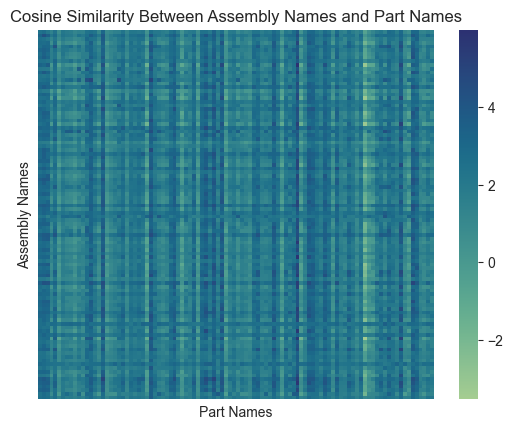

In [136]:
ax = sns.heatmap(similarity_batches[0], cmap="crest", xticklabels=False, yticklabels=False) #, annot=True)
ax.set(xlabel="Part Names", ylabel="Assembly Names", title="Cosine Similarity Between Assembly Names and Part Names")

In [137]:
pred = []
true = []
for index, value in enumerate(similarity_batches[0][:10]):
    predicted = np.argmax(value)
    actual = index
    pred.append(predicted)
    true.append(actual)
    print(f"Predicted: {predicted} | Actual: {index}")

Predicted: 65 | Actual: 0
Predicted: 65 | Actual: 1
Predicted: 65 | Actual: 2
Predicted: 65 | Actual: 3
Predicted: 91 | Actual: 4
Predicted: 28 | Actual: 5
Predicted: 94 | Actual: 6
Predicted: 65 | Actual: 7
Predicted: 65 | Actual: 8
Predicted: 65 | Actual: 9


In [138]:
def evaluate_accuracy(similarity_batches):
    top_ks = [1,5,10]
    for k in top_ks:
        tot_accuracy = []
        for batch in similarity_batches:
            top_k_values = np.argsort(-batch, axis=1)[:,:k]
            correct = 0
            for index, row in enumerate(top_k_values):
                if index in row:
                    correct += 1
            accuracy = correct / len(batch)
            tot_accuracy.append(accuracy)


        print(f"Top-{k} accuracy: {np.mean(tot_accuracy)}")

In [139]:
evaluate_accuracy(similarity_batches)

Top-1 accuracy: 0.056829268292682936
Top-5 accuracy: 0.15682926829268293
Top-10 accuracy: 0.2378048780487805


## Fine-tuned BERT

### Load test data

In [ ]:
test_data = pd.read_csv('data/test.csv')

In [ ]:
test_strings, test_labels = create_sentences(data.loc[test_data['Unnamed: 0'].tolist()])

In [ ]:
test_strings[:5]

In [ ]:
test_labels[:5]

In [124]:
test_data = pd.read_csv('data/test.csv')

In [125]:
test_strings, test_labels = create_sentences(data.loc[test_data['Unnamed: 0'].tolist()])

100%|██████████| 12321/12321 [00:00<00:00, 18441.83it/s]


In [126]:
test_strings[:5]

['An assembly containing the following parts: side 2, side 1, end 2, end 1, short divider, long divider.',
 'An assembly containing the following parts: 20mm stack.',
 'An assembly containing the following parts: basetopkey, basebottomkeyhalf, boxlid, windholder, basebottomkeyotherhalf, internalcomb, mainbox, barform.',
 'An assembly containing the following parts: hub build plate prt12, component, l 2112kk cage, bl touch, nut driver prt3, fake support, 177, wheel b1, pivot pin, carriage mount 2 prt10, 168, 166, 159, extruder grove wheel\\x2\\00d8\\x0\\13, boden frame, motor shaft, carrage mount prt8, heater, microswitch 1a 125v ac seul, 165, plate mount prt9, z screw, pin\\x2\\00d8\\x0\\5, turbine, 175, 147, shaft top prt4, stepper prt1, 184, l 2112kk ball, spacer 5x10x6.35, 157, pcb^endstop, aluminum spacer 20mm, heatsink^e3d nozzle v, 5972k154, 152, main body, extruder body alumium, heater block^e3d nozzle v, solid, 182, vt1m3x30, 144, carrage prt6, open rail gantry plate 60mm, arm,

In [127]:
test_labels[:5]

["An assembly with the name 'box shell version'",
 "An assembly with the name '20mm stack'",
 "An assembly with the name 'ww sport base bar box'",
 "An assembly with the name 'circle builder'",
 "An assembly with the name '2238 375.step'"]

### Load fine-tuned model from checkpoint and get embeddings

In [128]:
checkpoint_dir = 'MLM/fine_tuning/bert_fine_tuned_2'
bert_tokenizer_2 = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model_2 = TFBertModel.from_pretrained(checkpoint_dir)

Some layers from the model checkpoint at MLM/fine_tuning/bert_fine_tuned_2 were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at MLM/fine_tuning/bert_fine_tuned_2 and are newly initialized: ['bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [129]:
test_strings_embeddings, test_labels_embeddings = create_embeddings(test_strings, test_labels, bert_tokenizer_2, bert_model_2)

100%|██████████| 123/123 [01:37<00:00,  1.26it/s]


### Evaluate

## CLIP-like Contrastive Pre-training

### Load test data and create data loader for training data

In [57]:
train_data_path = '../data/train.csv'
test_data_raw = pd.read_csv('../data/test.csv')

In [52]:
# test_strings, test_labels = create_sentences(data.loc[test_data['Unnamed: 0'].tolist()])

100%|██████████| 12321/12321 [00:00<00:00, 16042.80it/s]


In [111]:
def preprocess_data(raw_data, wanted_data, tokenizer, max_length=128):
    part_name_sentences, assembly_name_sentences = create_sentences(raw_data.loc[wanted_data['Unnamed: 0'].tolist()])

    parts_tokens = tokenizer(part_name_sentences,
                  max_length=max_length,
                  truncation=True,
                  padding=True,
                  return_tensors='tf')

    # Extract encoded features and labels, add to corresponding lists
    part_input_ids = np.array(parts_tokens["input_ids"], dtype="int32")
    part_attention_masks = np.array(parts_tokens["attention_mask"], dtype="int32")
    part_token_type_ids = np.array(parts_tokens["token_type_ids"], dtype="int32")

    assemblies_tokens = tokenizer(assembly_name_sentences,
                  max_length=max_length,
                  truncation=True,
                  padding=True,
                  return_tensors='tf')

    # Extract encoded features and labels, add to corresponding lists
    assembly_input_ids = np.array(assemblies_tokens["input_ids"], dtype="int32")
    assembly_attention_masks = np.array(assemblies_tokens["attention_mask"], dtype="int32")
    assembly_token_type_ids = np.array(assemblies_tokens["token_type_ids"], dtype="int32")


    # return [[part_input_ids, part_attention_masks, part_token_type_ids], [assembly_input_ids, assembly_attention_masks, assembly_token_type_ids]]
    return [assemblies_tokens, parts_tokens]

In [112]:
class DataGeneratorFromFile(tf.keras.utils.Sequence):
    def __init__(self,
                 tokenizer,
                 n_examples,
                 data_filename,
                 max_length=128,
                 batch_size=32,
                 shuffle=True):

        self.tokenizer = tokenizer
        self.n_examples = n_examples
        self.data_filename = data_filename
        self.max_length = max_length
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Initialize row order, call on_epoch_end to shuffle row indices
        self.row_order = np.arange(1, self.n_examples+1)
        self.on_epoch_end()

    def __len__(self):
        return self.n_examples // self.batch_size

    def __getitem__(self, idx):
        batch_start = idx * self.batch_size
        batch_end = (idx + 1) * self.batch_size

        # Indices to skip are the ones in the shuffled row_order before and
        # after the chunk we'll use for this batch
        batch_idx_skip = self.row_order[:batch_start] + self.row_order[batch_end:]
        train_data_df = pd.read_csv(self.data_filename, skiprows=batch_idx_skip)

        batch_data = preprocess_data(
            data,
            train_data_df,
            self.tokenizer,
            self.max_length
        )

        return batch_data

    def on_epoch_end(self):
        if self.shuffle:
            self.row_order = list(np.random.permutation(self.row_order))

In [113]:
test_data = preprocess_data(data, test_data_raw, tokenizer=bert_tokenizer, max_length=128)
# print(np.array(test_data).shape)

100%|██████████| 12321/12321 [00:00<00:00, 17890.19it/s]


## Build Model

In [114]:
# Implement the text encoder
def create_text_encoder(train_layers=5, bert_model_name='bert-base-uncased', max_length=128):
    bert_model = TFAutoModel.from_pretrained(bert_model_name)

    if train_layers == -1:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False
    else:
        # Restrict training to the train_layers outer transformer layers
        retrain_layers = []
        for retrain_layer_number in range(train_layers):
            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)
        print('retrain layers: ', retrain_layers)
        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                print('freezing: ', w)
                w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)
    # pooled_token = bert_out[1]
    cls_token = bert_out[0][:, 0, :]

    model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[cls_token], name='text_encoder')
    return model

In [124]:
# Implement the dual encoder
class DualEncoder(keras.Model):
    def __init__(self, text_encoder, temperature=1.0, **kwargs):
        super(DualEncoder, self).__init__(**kwargs)
        self.text_encoder = text_encoder
        self.temperature = temperature
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, inputs, training=False):
        print(inputs)
        assemblies_tokens, parts_tokens = inputs[0], inputs[1]
        print(assemblies_tokens[0].shape())
        assembly_embeddings = self.text_encoder(assemblies_tokens, training=training)
        parts_embeddings = self.text_encoder(parts_tokens, training=training)

        return assembly_embeddings, parts_embeddings

    def compute_loss(self, assembly_embeddings, parts_embeddings):
        # logits[i][j] is the dot_similarity(caption_i, image_j).
        logits = (
            tf.matmul(assembly_embeddings, parts_embeddings, transpose_b=True)
            / self.temperature
        )
        # images_similarity[i][j] is the dot_similarity(image_i, image_j).
        parts_similarity = tf.matmul(
            parts_embeddings, parts_embeddings, transpose_b=True
        )
        # captions_similarity[i][j] is the dot_similarity(caption_i, caption_j).
        assembly_similarity = tf.matmul(
            assembly_embeddings, assembly_embeddings, transpose_b=True
        )
        # targets[i][j] = avarage dot_similarity(caption_i, caption_j) and dot_similarity(image_i, image_j).
        targets = keras.activations.softmax(
            (parts_similarity + assembly_similarity) / (2 * self.temperature)
        )
        # Compute the loss for the captions using crossentropy
        assembly_loss = keras.losses.categorical_crossentropy(
            y_true=targets, y_pred=logits, from_logits=True
        )
        # Compute the loss for the images using crossentropy
        parts_loss = keras.losses.categorical_crossentropy(
            y_true=tf.transpose(targets), y_pred=tf.transpose(logits), from_logits=True
        )
        # Return the mean of the loss over the batch.
        return (assembly_loss + parts_loss) / 2

    def train_step(self, features):
        with tf.GradientTape() as tape:
            # Forward pass
            assembly_embeddings, parts_embeddings = self(features, training=True)
            loss = self.compute_loss(assembly_embeddings, parts_embeddings)
        # Backward pass
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        # Monitor loss
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, features):
        assembly_embeddings, parts_embeddings = self(features, training=False)
        loss = self.compute_loss(assembly_embeddings, parts_embeddings)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [125]:
# Train the dual encoder model
num_epochs = 5  # In practice, train for at least 30 epochs
batch_size = 256

text_encoder = create_text_encoder(train_layers=5, hidden_size = 200, dropout=0.3, learning_rate=0.00005, max_length=128)
dual_encoder = DualEncoder(text_encoder, temperature=0.05)
dual_encoder.compile(optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.001))

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


retrain layers:  ['_11', '_10', '_9', '_8', '_7']


In [126]:
train_data_generator = DataGeneratorFromFile(
    tokenizer=bert_tokenizer,
    n_examples=len(pd.read_csv('../data/train.csv')),
    data_filename=train_data_path,
    batch_size=100
)

# Create a learning rate scheduler callback.
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3)
# Create an early stopping callback.
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = dual_encoder.fit(
    train_data_generator,
    epochs=num_epochs,
    validation_data=test_data,
    callbacks=[reduce_lr] # , early_stopping],
)
print("Training completed. Saving text encoder...")
text_encoder.save("text_encoder")
print("Models are saved.")

100%|██████████| 100/100 [00:00<00:00, 7138.03it/s]


{'input_ids': <tf.Tensor: shape=(100, 27), dtype=int32, numpy=
array([[ 101, 2019, 3320, ...,    0,    0,    0],
       [ 101, 2019, 3320, ...,    0,    0,    0],
       [ 101, 2019, 3320, ...,    0,    0,    0],
       ...,
       [ 101, 2019, 3320, ...,    0,    0,    0],
       [ 101, 2019, 3320, ..., 2243, 1005,  102],
       [ 101, 2019, 3320, ...,    0,    0,    0]])>, 'token_type_ids': <tf.Tensor: shape=(100, 27), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(100, 27), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0]])>}


KeyError: 'Exception encountered when calling layer "dual_encoder_10" "                 f"(type DualEncoder).\n\nIndexing with integers (to access backend Encoding for a given batch index) is not available when using Python based tokenizers\n\nCall arguments received by layer "dual_encoder_10" "                 f"(type DualEncoder):\n  • inputs={\'input_ids\': \'tf.Tensor(shape=(100, 27), dtype=int32)\', \'token_type_ids\': \'tf.Tensor(shape=(100, 27), dtype=int32)\', \'attention_mask\': \'tf.Tensor(shape=(100, 27), dtype=int32)\'}\n  • training=False'

In [97]:
text_encoder.summary()

Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                       

In [98]:
dual_encoder.summary()

Model: "dual_encoder_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_encoder (Functional)   (None, 768)               109482240 
                                                                 
Total params: 109,482,242
Trainable params: 109,482,240
Non-trainable params: 2
_________________________________________________________________


In [132]:
for index, value in enumerate(similarity_batches[0][:10]):
    predicted = np.argmax(value)
    actual = index
    print(f"Predicted: {predicted} | Actual: {index}")

Predicted: 65 | Actual: 0
Predicted: 65 | Actual: 1
Predicted: 12 | Actual: 2
Predicted: 65 | Actual: 3
Predicted: 4 | Actual: 4
Predicted: 65 | Actual: 5
Predicted: 65 | Actual: 6
Predicted: 65 | Actual: 7
Predicted: 65 | Actual: 8
Predicted: 65 | Actual: 9


In [133]:
evaluate_accuracy(similarity_batches)

Top-1 accuracy: 0.09495934959349595
Top-5 accuracy: 0.20813008130081304
Top-10 accuracy: 0.30308943089430895
